In [6]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef
import moyra.frames as fr

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

In [7]:
from sympy.abc import t as _t

In [8]:
DoFs = 7

# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(DoFs)

## pendulum mass
p.m = ma.ModelSymbol(value = 0.3,string = 'm')
p.L = ma.ModelSymbol(value = 0.3,string = 'L')
p.c = ma.ModelSymbol(value = 0.3,string = 'c')
p.I_xx = ma.ModelSymbol(value = 0.3,string = 'I_xx')
p.I_yy = ma.ModelSymbol(value = 0.3,string = 'I_yy')
p.I_zz = ma.ModelSymbol(value = 0.3,string = 'I_zz')
p.I_xy = ma.ModelSymbol(value = 0.3,string = 'I_xy')
p.I_xz = ma.ModelSymbol(value = 0.3,string = 'I_xz')
p.I_yz = ma.ModelSymbol(value = 0.3,string = 'I_yz')
p.x = ma.ModelSymbol(value = 0.3,string = 'x')
p.y = ma.ModelSymbol(value = 0.3,string = 'y')
p.z = ma.ModelSymbol(value = 0.3,string = 'z')
p.EI = ma.ModelSymbol(value = 0.3,string = 'EI')

p.y_0,p.x_0 = sym.symbols('y_0,x_0')

#gravity vector
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point

In [9]:
S,tau_0 = ele.FlexiElement.ShapeFunctions_OBM_IBN_TO(1,0,0,p.q[-1],p.y_0,p.x_0,0,1,type='taylor')
z_0 = (S*sym.Matrix([p.q[-1]]))[2]
# z_0 = z_0.subs({p.x_0:0})
#define refernce frames
body_frame= fr.HomogenousFrame().Translate(*p.q[:3]).R_x(p.q[3]).R_y(p.q[4]).R_z(p.q[5]).Translate(p.x_0,p.y_0,z_0)

In [11]:
#Create Elemnts
# Link 1
M_link1 = ele.MassMatrix(p.m/p.L)
link1_x__int = (p.x_0,-p.c*sym.Rational(1,2),p.c*sym.Rational(1,2))
link1_y_int = (p.y_0,0,p.L)
link_1 = ele.FlexiElement(body_frame,p.m/p.L,S,link1_x__int,link1_y_int,0,p.q[-1],p.EI,0,gravityPot=True)

In [12]:
# %%timeit -r 1 -n 1
# %%prun -D "C:\Users\qe19391\OneDrive - University of Bristol\Desktop\dump2.prof"
sm2 = ma.SymbolicModel.FromElementsAndForces(p,link_1)
sm2 = sm2.subs({p.g_v[0]:0,p.g_v[1]:0,p.g_v[2]:-1})

0


In [13]:
S,tau = ele.FlexiElement.ShapeFunctions_OBM_IBN_TO(1,0,0,p.q[-1],p.y_0,p.x_0,0,1,type='taylor')
body_frame = fr.ReferenceFrame.EulerAnglesXYZ(p.q[0:3],p.q[3:6])

In [14]:
link2_x__int = (p.x_0,-p.c*sym.Rational(1,2),p.c*sym.Rational(1,2))
link2_y_int = (p.y_0,0,p.L)
link_2 = ele.FlexiElement(body_frame,p.m/p.L,S,link2_x__int,link2_y_int,0,p.q[-1],p.EI,0,gravityPot=True)

In [15]:
# %%timeit -r 1 -n 1
# %%prun -D "C:\Users\qe19391\OneDrive - University of Bristol\Desktop\dump2.prof"
sm = ma.SymbolicModel.FromElementsAndForces(p,[link_2])
sm = sm.subs({p.g_v[0]:0,p.g_v[1]:0,p.g_v[2]:-1})

0


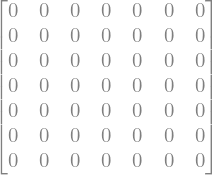

In [16]:
sym.simplify(sm.M-sm2.M)

In [17]:
sym.simplify(sm.f-sm2.f)

In [11]:
body_frame2= ma.HomogenousTransform().Translate(*p.q[:3]).R_x(p.q[3]).R_y(p.q[4]).R_z(p.q[5])
# body_frame= ma.HomogenousShaba.EulerAnglesXYZ(sym.Matrix(p.q[:3]),sym.Matrix(p.q[3:6]))
#Create Elemnts
M = ele.MassMatrix(p.m,p.I_xx,p.I_yy,p.I_zz,p.I_xy,p.I_xz,p.I_yz)
body2 = ele.RigidElement(body_frame2,M,gravityPotential=True)

In [14]:
# %%timeit -r 1 -n 1
sm2 = ma.SymbolicModel.FromElementsAndForces(p,[body2])
sm2 = sm2.subs({p.g_v[0]:0,p.g_v[1]:0,p.g_v[2]:-1})

0


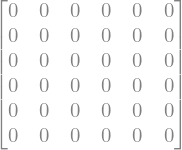

In [15]:
sym.simplify(sm.M-sm2.M)

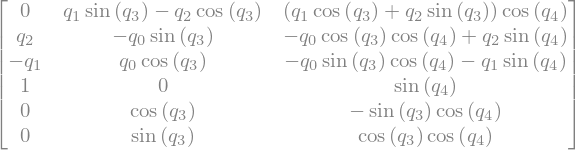

In [16]:
sym.simplify(body_frame.ManipJacobian(p.q[3:]))

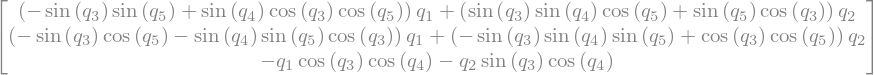

In [17]:
sym.simplify(body_frame.R.T*body_frame.t).diff(p.q[3])

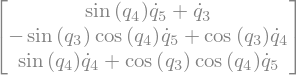

In [23]:
thetad = body_frame.theta.diff(me.dynamicsymbols._t)
body_frame.G*thetad-

In [18]:
sym.simplify(body_frame.R*Wedge3(body_frame.t)*body_frame.G)

NameError: name 'Wedge3' is not defined

In [15]:
def Vee3(S):
    return sym.Matrix([S[2,1],S[0,2],S[1,0]])
def Wedge3(V):
    val = sym.Matrix([[0]*3]*3)
    val[0,1] = -V[2]
    val[1,0] = V[2]
    val[2,0] = -V[1]
    val[0,2] = V[1]
    val[1,2] = -V[0]
    val[2,1] = V[0]
    return val    

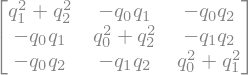

In [166]:
test = sym.Matrix(p.q[:3])
Wedge3(test).T*Wedge3(test)

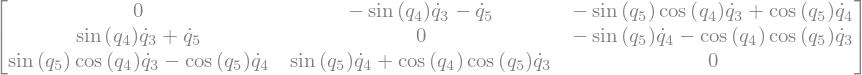

In [146]:
S = sym.simplify(body_frame.R.T*body_frame.R.diff(me.dynamicsymbols._t))
S

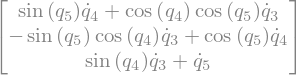

In [147]:
V = Vee3(S)
V

In [148]:
Gb = V.jacobian(p.qd[3:])

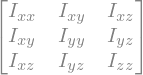

In [149]:
M[3:,3:]

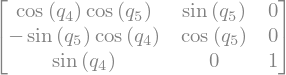

In [150]:
Gb

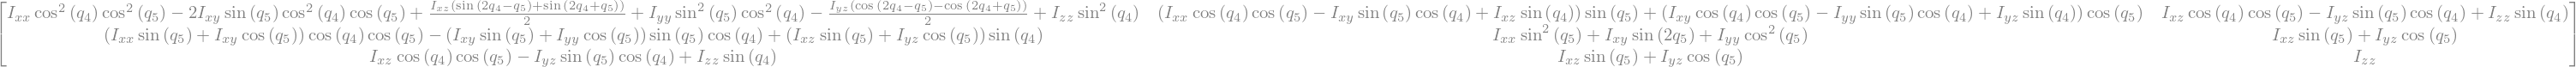

In [151]:
sym.simplify(Gb.T*M[3:,3:]*Gb)

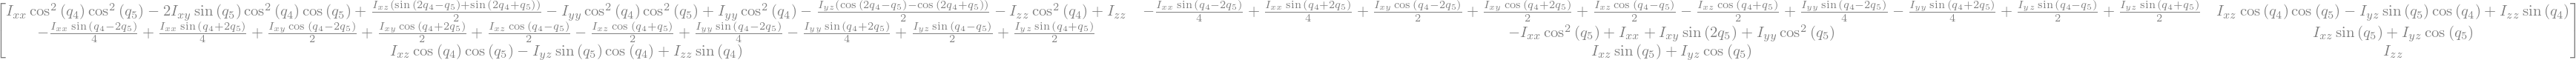

In [152]:
sym.simplify(sm.M[3:,3:])

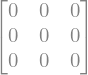

In [153]:
sym.simplify(sm.M[3:,3:]-Gb.T*M[3:,3:]*Gb)

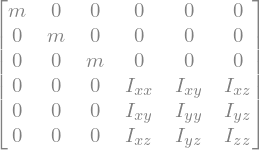

In [154]:
M

In [155]:
DoFs = 7

# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(DoFs)

## pendulum mass
p.m = ma.ModelSymbol(value = 0.3,string = 'm')
p.I_xx = ma.ModelSymbol(value = 0.3,string = 'I_xx')
p.I_yy = ma.ModelSymbol(value = 0.3,string = 'I_yy')
p.I_zz = ma.ModelSymbol(value = 0.3,string = 'I_zz')
p.I_xy = ma.ModelSymbol(value = 0.3,string = 'I_xy')
p.I_xz = ma.ModelSymbol(value = 0.3,string = 'I_xz')
p.I_yz = ma.ModelSymbol(value = 0.3,string = 'I_yz')

#gravity vector
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point

In [168]:
body_frame= ma.HomogenousTransform().Translate(*p.q[:3]).R_euler_params(p.q[3:])
#Create Elements
M = ele.MassMatrix(p.m,p.I_xx,p.I_yy,p.I_zz,p.I_xy,p.I_xz,p.I_yz)
body = ele.RigidElement(body_frame,M,gravityPotential=True)

In [172]:
o =body_frame.R.diff(me.dynamicsymbols._t)*body_frame.R

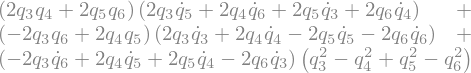

In [178]:
o[0,1]

In [ ]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[body])

In [ ]:
sym.simplify(sm.M[1,1])

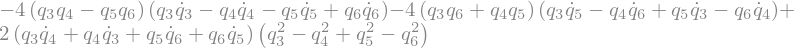

In [175]:
R = body_frame.R

om = R.diff(me.dynamicsymbols._t)*R.T
test = R.diff(me.dynamicsymbols._t)*R.T
sym.simplify(test[2,1])

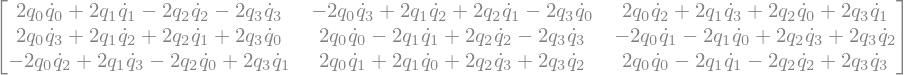

In [68]:
R.diff(me.dynamicsymbols._t)

In [63]:
c = p.q[3]**2+p.q[4]**2+p.q[5]**2+p.q[6]**2
c

In [64]:
c.diff(me.dynamicsymbols._t)

In [53]:
R2 = - c*sym.eye(3) + R
test = sym.simplify(R2.diff(me.dynamicsymbols._t)*R2.T)[1,1].expand()

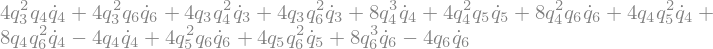

In [56]:
cc = p.q[3]**2+p.q[4]**2+p.q[5]**2+p.q[6]**2
ct = cc.diff(me.dynamicsymbols._t)
test.collect(ct)

In [57]:
ct

In [34]:
polysimp = lambda expr, eqs: sym.ratsimpmodprime(expr, sym.groebner(eqs).exprs)

In [36]:
polysimp(R[1,1],c)

TypeError: object of type 'Add' has no len()

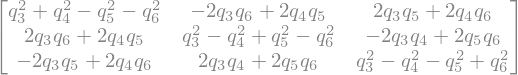

In [37]:
R